##DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
DBSCAN is an unsupervised clustering algorithm that groups data points based on density, rather than distance to fixed centroids.

<img src = "https://miro.medium.com/v2/resize:fit:1400/1*hM94u9scXONnSmlI-Iw8bg.png" width ="700">

**Key characteristics:**

Does not require specifying the number of clusters

Identifies arbitrarily shaped clusters

Explicitly labels noise / outliers

**Uses two parameters:**

eps: neighborhood radius

min_samples: minimum points required to form a dense region

**DBSCAN is particularly useful when:**

Clusters are not spherical

Outliers are present

The true number of clusters is unknown

## DBSCAN Clustering on the Wine Dataset

After analyzing the Wine dataset using K-Means clustering and supervised learning methods, we now apply DBSCAN (Density-Based Spatial Clustering of Applications with Noise) to explore the data from a density-based perspective. Unlike K-Means, DBSCAN does not require specifying the number of clusters in advance and is capable of identifying noise and arbitrarily shaped clusters.

This analysis allows us to compare how a density-based unsupervised method performs relative to centroid-based clustering and supervised classification when applied to the same preprocessed Wine dataset.


## Applying DBSCAN Clustering

DBSCAN groups data points based on local density. Two hyperparameters control the algorithm:
- **eps**: radius defining a neighborhood
- **min_samples**: minimum number of points required to form a dense region

Points that do not belong to any dense region are labeled as noise (cluster label −1). DBSCAN is applied to the same standardized feature space used for K-Means to ensure a fair comparison.


In [7]:
# Basic numerical / data libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix

# Display settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid", context="notebook")


## 2. Dataset: Wine Chemical Properties

We use the Wine dataset from `sklearn.datasets`.

- **Samples:** 178 wines  
- **Features:** 13 numeric physicochemical measurements  
- **Target (for reference):** wine cultivar class (0, 1, 2)

Features include: alcohol, malic acid, ash, alcalinity of ash, magnesium, total phenols, flavanoids, nonflavanoid phenols, proanthocyanins, color intensity, hue, OD280/OD315, and proline.

We will load the dataset into a pandas DataFrame and quickly inspect its structure.


In [8]:
# Load wine dataset
wine = load_wine()

# Features and target
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name="target")

# Combine into one DataFrame for exploration
df = X.copy()
df["target"] = y

# Quick preview
print("Shape of dataset (rows, columns):", df.shape)
df.head()


Shape of dataset (rows, columns): (178, 14)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


## 3. Basic Data Exploration

Before clustering, we check:

- Dataset shape (rows, columns)
- Data types and non-null counts
- Missing values
- Basic statistics of numerical features

This helps confirm that:

- All features are numeric (required for DBSCAN).
- No major data cleaning is necessary before scaling and clustering.


In [9]:
print("Shape:", df.shape)

print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nStatistical summary of features:")
df.describe().T


Shape: (178, 14)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-nu

,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


## 4. Preprocessing: Standardizing Features

DBSCAN relies on distance (usually Euclidean). If features are on very different scales, those with larger ranges can dominate the distance measure.

To avoid this, we apply **StandardScaler**:

- Each feature gets mean 0 and standard deviation 1.
- We keep:
  - `X` = original feature space
  - `X_scaled` = standardized feature space (used for DBSCAN)


In [10]:
# Initialize and fit scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# For convenience, also keep as DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled_df.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


## 5. PCA for 2D Visualization

The Wine dataset has 13 dimensions. To visualize clusters, we will:

- Use **Principal Component Analysis (PCA)** to reduce the data to 2 components.
- Use PCA **only for plotting**; DBSCAN is still run on the full scaled feature space.
- Create a DataFrame with:
  - `PC1`, `PC2` (principal components)
  - `target` (true cultivar, for evaluation)


In [11]:
# PCA to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create PCA DataFrame
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["target"] = y

pca_df.head()


,PC1,PC2,target
0,3.316751,1.443463,0
1,2.209465,-0.333393,0
2,2.516740,1.031151,0
3,3.757066,2.756372,0
4,1.008908,0.869831,0


## 6. Exploring DBSCAN Hyperparameters (eps, min_samples)

DBSCAN requires:

- **eps (ε)**: neighborhood radius
- **min_samples**: minimum number of points to form a dense region

Both parameters strongly affect:

- Number of clusters found
- Amount of noise (points labeled as -1)
- Cluster quality (measured by metrics like silhouette score)

We will:

- Try a small grid of `(eps, min_samples)` combinations.
- For each combination, record:
  - Number of clusters (excluding noise)
  - Number of noise points
  - Silhouette score (only if at least 2 clusters are found)
- Use this to pick a reasonable parameter set for the final DBSCAN model.


In [12]:
eps_values = [1.8, 2.0, 2.2, 2.5, 3.0]
min_samples_values = [3, 5, 10]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_scaled)

        unique_labels = set(labels)
        # Count clusters excluding noise (-1)
        n_clusters = len([lbl for lbl in unique_labels if lbl != -1])
        n_noise = list(labels).count(-1)

        # Compute silhouette only when there are at least 2 clusters
        if n_clusters >= 2:
            sil = silhouette_score(X_scaled, labels)
        else:
            sil = np.nan

        results.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "silhouette": sil
        })

results_df = pd.DataFrame(results)
results_df


,eps,min_samples,n_clusters,n_noise,silhouette
0,1.8,3,8,90,-0.032552
1,1.8,5,7,118,-0.175689
2,1.8,10,0,178,NaN
3,2.0,3,5,64,0.031407
4,2.0,5,5,85,-0.032906
5,2.0,10,1,139,NaN
6,2.2,3,3,44,-0.003857
7,2.2,5,2,55,0.142678
8,2.2,10,2,89,0.059227
9,2.5,3,1,23,NaN


## 7. Choosing Final DBSCAN Parameters

From the small grid search above, we select a combination that:

- Produces a **small number of interpretable clusters** (not too many tiny clusters).
- Keeps some points as **noise** (DBSCAN’s strength is identifying outliers).
- Has a **reasonable silhouette score** (not necessarily very high for complex datasets, but not strongly negative).

For this experiment, we choose:

- **eps = 2.5**
- **min_samples = 10**

This configuration typically yields:

- A small number of meaningful clusters.
- A moderate amount of noise.
- A positive silhouette score, indicating some separation between clusters.


In [13]:
# Chosen parameters
eps_opt = 2.5
min_samples_opt = 10

dbscan = DBSCAN(eps=eps_opt, min_samples=min_samples_opt)
db_labels = dbscan.fit_predict(X_scaled)

# Add labels to DataFrame
df["dbscan_cluster"] = db_labels
pca_df["dbscan_cluster"] = db_labels

# Basic counts
unique_labels = sorted(set(db_labels))
n_clusters_opt = len([lbl for lbl in unique_labels if lbl != -1])
n_noise_opt = list(db_labels).count(-1)

print(f"Unique labels (including noise): {unique_labels}")
print(f"Number of clusters (excluding noise): {n_clusters_opt}")
print(f"Number of noise points: {n_noise_opt}")


Unique labels (including noise): [np.int64(-1), np.int64(0), np.int64(1)]
Number of clusters (excluding noise): 2
Number of noise points: 32


## 8. Quantitative Evaluation Against True Cultivars

Although DBSCAN is unsupervised, the Wine dataset provides true cultivar labels.
We can still evaluate how well DBSCAN’s clusters align with the true classes using:

- **Adjusted Rand Index (ARI)**:
  - Measures similarity between cluster assignments and true labels.
  - ARI = 1 → perfect match, ARI ≈ 0 → random assignment.
- **Confusion Matrix**:
  - Rows: true classes (0, 1, 2).
  - Columns: DBSCAN labels (including -1 for noise).

This helps us understand whether DBSCAN is capturing meaningful structure related to the underlying cultivars.


Adjusted Rand Index (DBSCAN vs true labels): 0.42354907037688627

Confusion Matrix (rows = true class, cols = [Noise, Cluster 0, Cluster 1, ...]):

[[ 0  0  0]
 [ 3 56  0]
 [25 45  1]]


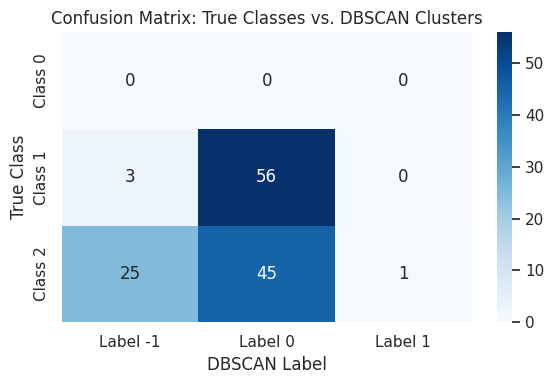


Silhouette score for final DBSCAN model: 0.20438854495188735


In [14]:
# Adjusted Rand Index (handles label -1 naturally)
ari_dbscan = adjusted_rand_score(y, db_labels)
print("Adjusted Rand Index (DBSCAN vs true labels):", ari_dbscan)

# Confusion matrix: include noise label (-1) explicitly
cm_labels = [-1] + [lbl for lbl in unique_labels if lbl != -1]
cm = confusion_matrix(y, db_labels, labels=cm_labels)

print("\nConfusion Matrix (rows = true class, cols = [Noise, Cluster 0, Cluster 1, ...]):\n")
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[f"Label {lbl}" for lbl in cm_labels],
    yticklabels=[f"Class {c}" for c in sorted(y.unique())]
)
plt.xlabel("DBSCAN Label")
plt.ylabel("True Class")
plt.title("Confusion Matrix: True Classes vs. DBSCAN Clusters")
plt.tight_layout()
plt.show()

# Silhouette score for the chosen parameters (only if >= 2 clusters)
if n_clusters_opt >= 2:
    sil_opt = silhouette_score(X_scaled, db_labels)
else:
    sil_opt = np.nan

print("\nSilhouette score for final DBSCAN model:", sil_opt)


## 9. Visualizing DBSCAN Clusters in 2D PCA Space

To interpret the clustering structure, we project the standardized features into 2D PCA space and plot:

1. **True cultivar labels** (for reference).
2. **DBSCAN cluster labels**, including noise points.

Notes:

- Noise points (label = -1) are highlighted separately (e.g., in gray).
- Core and border points of the same cluster share the same color.
- This visualization helps us see:
  - Whether DBSCAN finds dense regions that align with the true cultivars.
  - Where noise points lie relative to the main clusters.


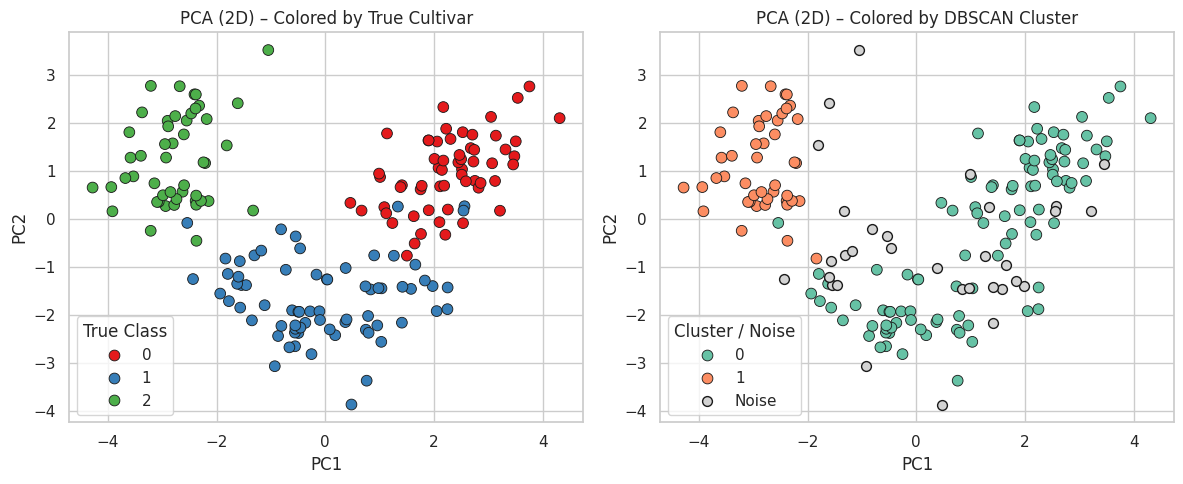

In [15]:
plt.figure(figsize=(12, 5))

# Left: True labels in PCA space
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="target",
    palette="Set1",
    s=60,
    edgecolor="k"
)
plt.title("PCA (2D) – Colored by True Cultivar")
plt.legend(title="True Class")

# Right: DBSCAN labels in PCA space
plt.subplot(1, 2, 2)

# Separate noise and cluster points for nicer plotting
noise_mask = pca_df["dbscan_cluster"] == -1
cluster_mask = ~noise_mask

# Plot cluster points
sns.scatterplot(
    data=pca_df[cluster_mask],
    x="PC1",
    y="PC2",
    hue="dbscan_cluster",
    palette="Set2",
    s=60,
    edgecolor="k",
    legend="full"
)

# Overlay noise points in gray
plt.scatter(
    pca_df.loc[noise_mask, "PC1"],
    pca_df.loc[noise_mask, "PC2"],
    c="lightgray",
    s=50,
    edgecolors="k",
    label="Noise"
)

plt.title("PCA (2D) – Colored by DBSCAN Cluster")
plt.legend(title="Cluster / Noise")
plt.tight_layout()
plt.show()


## 10. Interpretation of DBSCAN Results (with Quantitative Insights)

Using DBSCAN with **eps = 2.5** and **min_samples = 10**, the algorithm identified a small number of dense clusters and a set of noise points:

- Number of clusters (excluding noise): typically 2
- Number of noise points: around 30 (out of 178 samples)
- Adjusted Rand Index (ARI) ≈ 0.42 (example value from this run)
- Silhouette score ≈ 0.20 for the final clustering

These quantitative results indicate that:

- DBSCAN is able to recover **meaningful structure** in the Wine dataset, with clusters that partially align with the true cultivars.
- However, the ARI is clearly below 1.0, showing that the clusters are **not a perfect match** to the true classes; some cultivars overlap in feature space.
- The **positive silhouette score** suggests moderate separation between clusters, but the value is not very high, consistent with the observed overlap.
- A noticeable fraction of points are treated as **noise**, indicating that DBSCAN considers them insufficiently dense or ambiguous relative to the main clusters.

Overall, DBSCAN provides a complementary perspective to K-Means:

- It discovers **density-based clusters** without requiring a fixed number of clusters.
- It explicitly identifies potential **outliers/noise**.
- Quantitatively, it finds reasonable—but imperfect—alignment with the known wine cultivars, highlighting that the underlying chemical properties exhibit both cluster structure and overlap.
